<a href="https://colab.research.google.com/github/raindrop314159/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [5]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

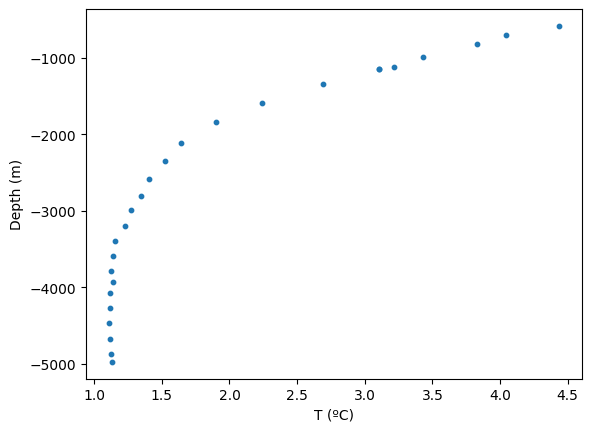

In [6]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2025-11-11 22:26:10,259 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


Text(0, 0.5, 'Depth (m)')

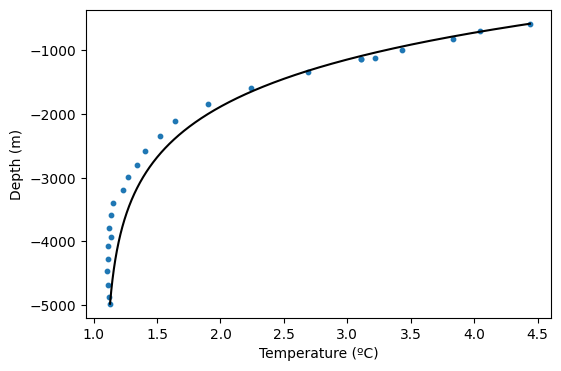

In [7]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=1e-4 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

ADD DISCUSSION HERE

Diffusivity $\kappa = 10^{-4}$  gives a good match.

The steady advection/diffusion model demonstrates a reasonable fit to the temperature data at shallower depths, specifically from 0 to -1500 m. However, as depth increases beyond -1500 m, the model's accuracy declines. Specifically, between -3000 m and -5000 m, the actual temperature measurements exhibit a steeper gradient than the model predicts. Also, the observed data show more fluctuations, while the modeled values present a smoother curve. This suggests that the model may not fully capture the complexities of temperature variation at greater depths, indicating potential limitations in its ability to account for dynamic processes influencing heat distribution in the deep ocean. On the other hand, note that instruments may not perform as reliably in the deep ocean. Considering that the data was obtained in 1966 (Munk, 1966), fluctuations may reflect instrumental error rather than represent the actual temperature profile of deep ocean.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


2025-11-11 22:26:10,812 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


2025-11-11 22:26:10,943 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s


2025-11-11 22:26:10,999 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s


2025-11-11 22:26:11,056 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s


2025-11-11 22:26:11,112 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s


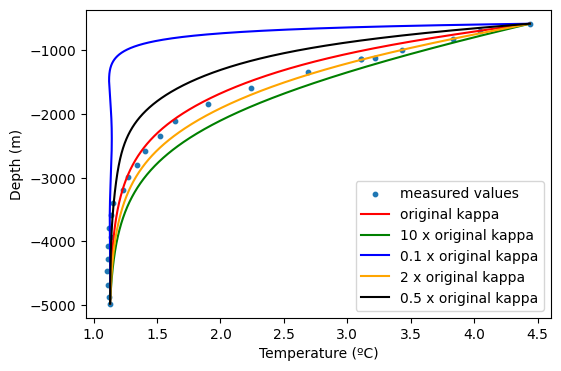

In [8]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 1e-8 # m/s
kappa_org = 1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667)
kappa_plus = 10*kappa_org
kappa_less = kappa_org/ 10
kappa_half = kappa_org*0.5
kappa_double = kappa_org*2

kappa_vals = [kappa_org, kappa_plus, kappa_less,kappa_half,kappa_double]
T_list = []

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

for kappa_i in kappa_vals:

  # Fields
  T = dist.Field(name='T', bases=zbasis)
  kappa = dist.Field(name='kappa_i', bases=zbasis)
  # Set the diffusivity
  # Below is the diffusivity profile from Rogers et al., 2023
  kappa['g']= kappa_i  # m^2/s

  # Add two tau variables to allow us to apply two boundary conditions
  tau_1 = dist.Field(name='tau_1')
  tau_2 = dist.Field(name='tau_2')
  lift_basis = zbasis.derivative_basis(1)
  lift = lambda A: d3.Lift(A, lift_basis, -1)

  # Substitutions
  dz = lambda A: d3.Differentiate(A, zcoord)
  Tz = dz(T) + lift(tau_1)
  Tzz = dz(Tz) + lift(tau_2)

  # Problem
  problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
  problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
  problem.add_equation("T(z=z_surface) = T_surface")
  problem.add_equation("T(z=z_bottom) = T_bottom")

  # Solver
  solver = problem.build_solver()
  solver.solve()
  T_list.append(T['g'])

# Plot
plt.figure(figsize=(6, 4))
#Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10, label = "measured values")
plt.plot(T_list[0], z, 'r', label="original kappa")
plt.plot(T_list[1], z, 'g', label="10 x original kappa")
plt.plot(T_list[2], z, 'b', label="0.1 x original kappa")
plt.plot(T_list[4], z, 'orange', label="2 x original kappa")
plt.plot(T_list[3], z, 'k', label="0.5 x original kappa")


plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.legend()
plt.show()

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the required vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

INSERT COMMENTS HERE

In terms of balance, since $w=0$, the absence of advection means that temperature changes are solely driven by diffusion.

$w=0$ implies that the diffusive heat flux $\frac{dT}{dz}$ is constant since $\frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$ = 0 where $\kappa$ is a non-zero constant.

A vertical velocity $w =10^8 m/s$  produces a good agreement.

Keeping the same vertical velocity $w =10^8 m/s$ as optimal $w$, $\kappa$ was varied by factors of 10, 0.1, 2, 0.5, and the results were plotted on the graph above. It was observed that optimal $w$ is rather sensitive to a change in $\kappa$. Also, the optimal $w$ is more sensitive to a decrease in $\kappa$ value compared to an increase of the same order of magnitude.

If $\kappa$ varies between regions of smooth and rough topography, the efficiency of heat transport could change dramatically across different oceanic regions since optimal $w$ is senstive to the change in $\kappa$. For example, in areas of rough topography, such as those featuring seamounts or complex seabed structures, increased turbulence can enhance mixing processes. This is bexause depth-dependent turbulent diffusivity $\kappa$ could be balanced by downwelling, with negative vertical velocities $(-w)$ in the ocean interior. Areas of downwelling (where cold water sinks) can then be balanced by upwelling zones (where warm water rises), which enhances overall circulation in the ocean interior. Upwelling brings nutrient-rich deep waters to the surface, supporting the marine ecosystems and helping to drive currents.

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [9]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+00/s


2025-11-11 22:26:11,604 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+00/s


INFO:__main__:Starting main loop


2025-11-11 22:26:11,609 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-11 22:26:12,251 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-11 22:26:12,275 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-11 22:26:12,297 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-11 22:26:12,320 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-11 22:26:12,342 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-11 22:26:12,364 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-11 22:26:12,385 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-11 22:26:12,410 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-11 22:26:12,433 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-11 22:26:12,457 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-11 22:26:12,480 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-11 22:26:12,504 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-11 22:26:12,530 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-11 22:26:12,552 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-11 22:26:12,576 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-11 22:26:12,599 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-11 22:26:12,622 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-11 22:26:12,645 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-11 22:26:12,671 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-11 22:26:12,694 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-11 22:26:12,718 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-11 22:26:12,741 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-11 22:26:12,764 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-11 22:26:12,789 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-11 22:26:12,812 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-11 22:26:12,836 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-11 22:26:12,859 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-11 22:26:12,882 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-11 22:26:12,905 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-11 22:26:12,927 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-11 22:26:12,950 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-11 22:26:12,981 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-11 22:26:13,010 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-11 22:26:13,033 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-11 22:26:13,059 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-11 22:26:13,084 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-11 22:26:13,106 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-11 22:26:13,135 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-11 22:26:13,157 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-11 22:26:13,180 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-11 22:26:13,202 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-11 22:26:13,225 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-11 22:26:13,251 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-11 22:26:13,274 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-11 22:26:13,297 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-11 22:26:13,322 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-11 22:26:13,346 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-11 22:26:13,368 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-11 22:26:13,391 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-11 22:26:13,419 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-11 22:26:13,442 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-11 22:26:13,466 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-11 22:26:13,489 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-11 22:26:13,512 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-11 22:26:13,536 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-11 22:26:13,559 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-11 22:26:13,583 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-11 22:26:13,606 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-11 22:26:13,629 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-11 22:26:13,652 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-11 22:26:13,676 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-11 22:26:13,700 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-11 22:26:13,723 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-11 22:26:13,746 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-11 22:26:13,768 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-11 22:26:13,792 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-11 22:26:13,816 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-11 22:26:13,842 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-11 22:26:13,865 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-11 22:26:13,887 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-11 22:26:13,911 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-11 22:26:13,934 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-11 22:26:13,958 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-11 22:26:13,981 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-11 22:26:14,005 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-11 22:26:14,044 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-11 22:26:14,069 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 22:26:14,088 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-11 22:26:14,090 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-11 22:26:14,091 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2819 sec


2025-11-11 22:26:14,092 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2819 sec


INFO:solvers:Warmup time (iter 0-10): 0.6626 sec


2025-11-11 22:26:14,093 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.6626 sec


INFO:solvers:Run time (iter 10-end): 1.817 sec


2025-11-11 22:26:14,094 solvers 0/1 INFO :: Run time (iter 10-end): 1.817 sec


INFO:solvers:CPU time (iter 10-end): 0.0005047 cpu-hr


2025-11-11 22:26:14,096 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005047 cpu-hr


INFO:solvers:Speed: 7.234e+06 mode-stages/cpu-sec


2025-11-11 22:26:14,097 solvers 0/1 INFO :: Speed: 7.234e+06 mode-stages/cpu-sec


In [10]:
def simulate_pollution(U0, kappa):
    import numpy as np
    import matplotlib.pyplot as plt
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)

  # Set parameters
    #U0 = 0.1 # maximum current speed in m/s
    w = 10 # width of the river in m
    L = 50 # length of the river section to simulate
    #kappa = 1e-2 # diffusivity in m^2/s
    S0 = 1 # amplitude of the pollution source term
    S_w = 1 # width of the source term in m
    S_x = 10 # center of the forcing in x
    S_y = 0 # center of the forcing in y
    S_t = 1 # forcing timescale

    # Numerical parameters
    Nx = 256 # number of gridoints in x
    Ny = 32 # number of gridpoints in y
    stop_sim_time=1500 # end time in seconds
    timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

    import numpy as np
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='c', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])];

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)

    return c_save, np.array(t_save)

Check whether the new function returns same output c_save:

In [12]:
#print(xbasis)
#print(c.global_shape)
#print(c_save.shape)
#c_concentration = simulate_pollution(U0=0.1, kappa=1e-2)
#diff = c_save - c_concentration
#print(diff)
#print(c_concentration.shape)
#frobenius_norm = np.linalg.norm(diff)/np.linalg.norm(c_save)
#print(frobenius_norm)


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-11 22:26:52,750 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpc31l55qf/temp.m4v


2025-11-11 22:26:52,751 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpc31l55qf/temp.m4v


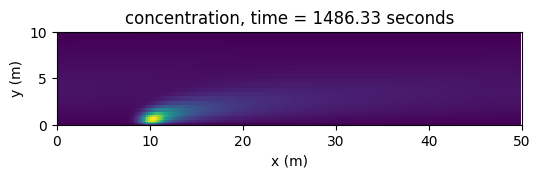

In [13]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
### Advective/diffusive timescales
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

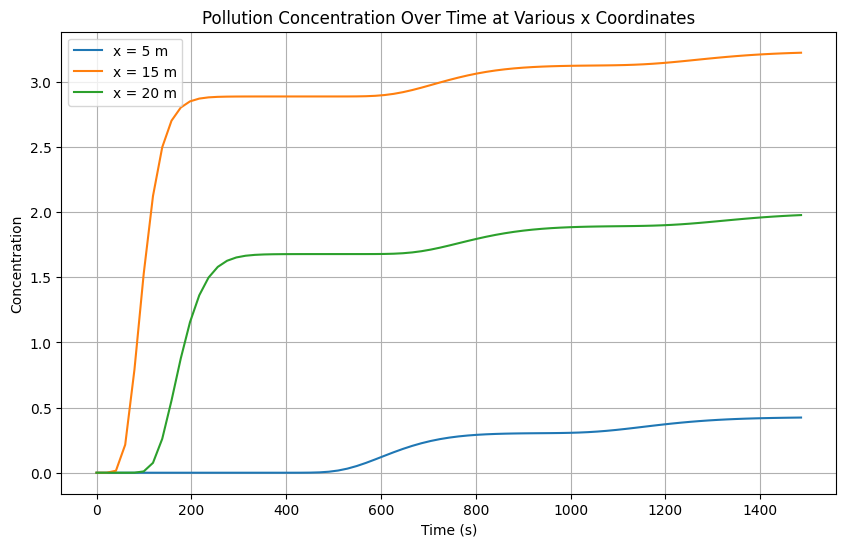

In [14]:
# Target coordinates
target_x = [5, 15, 20]  # Example x coordinates in meters
target_y = 2                # Example y coordinate in meters

# Prepare to plot
plt.figure(figsize=(10, 6))

for x_i in target_x:
    # Find the nearest indices
    x_indices = (np.abs(x - x_i)).argmin()  # Nearest x index from simulation grid
    y_indices = (np.abs(y - target_y)).argmin()  # Nearest y index from simulation grid

    # Extract the concentration data at the specified (x, y)
    concentration_over_time = c_save[:, x_indices, y_indices]

    # Plot the concentration over time
    plt.plot(t_save, concentration_over_time, label=f'x = {x_i} m')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various x Coordinates')
plt.legend()
plt.grid()
plt.show()

The source of pollutant is located at $x=10 m$ and flows in the positive direction. As a result, $x=15m (orange line)$ first sees an increase in concentration around $t=50s$. Then, $x=20m (green line)$ sees an increase shortly after at around $t=100s$. Finally, $x=5m (blue line)$, which is upstream of the pollutant source, sees an increase at around $t=500s$.

Vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters:

In [ ]:
# Target coordinates
target_x = 20  # Example x coordinates in meters
target_y = 2   # Example y coordinates in meters
# Find the nearest indices
x_indices = (np.abs(x - target_x)).argmin()  # Nearest x index from simulation grid
y_indices = (np.abs(y - target_y)).argmin()  # Nearest y index from simulation grid

# Prepare to plot for varying U0
plt.figure(figsize=(10, 6))
U_list = [0.1,1,10]
for U_i in U_list:
    c_concentration, t_sim_save = simulate_pollution(U0=U_i, kappa=1e-2)
    concentration_over_time = c_concentration[:, x_indices, y_indices]
    plt.plot(t_sim_save, concentration_over_time, label=f'U0 = {U_i} m/s')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various Maximum Current Speed (U0)')
plt.legend()
plt.grid()
plt.show()

At the very beginning, the initial rises in concentrations (from $t=0$ to $t=150$) can be observed more quickly as the corresponding $U_0$ increases. This is because the higher the maximum speed $U_0$, the more quickly the pollutant can be driven from $x=10$ to $x=20$.

However, after the concentrations start to increase, the lower the $U_0$, the higher the measured concentration value at $x=20$, $y=2$. This is because the higher the $U_0$, the quicker will the pollutant be washed away further downstream, avoiding accumulation at $x=20$, $y=2$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


2025-11-11 22:27:12,609 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


INFO:__main__:Starting main loop


2025-11-11 22:27:12,616 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-11 22:27:12,655 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-11 22:27:12,685 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-11 22:27:12,712 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-11 22:27:12,736 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-11 22:27:12,760 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-11 22:27:12,783 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-11 22:27:12,806 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-11 22:27:12,831 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-11 22:27:12,854 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-11 22:27:12,876 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-11 22:27:12,900 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-11 22:27:12,922 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-11 22:27:12,947 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-11 22:27:12,970 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-11 22:27:13,005 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-11 22:27:13,031 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-11 22:27:13,054 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-11 22:27:13,077 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-11 22:27:13,099 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-11 22:27:13,121 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-11 22:27:13,145 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-11 22:27:13,167 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-11 22:27:13,190 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-11 22:27:13,218 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-11 22:27:13,241 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-11 22:27:13,264 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-11 22:27:13,286 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-11 22:27:13,309 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-11 22:27:13,332 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-11 22:27:13,355 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-11 22:27:13,378 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-11 22:27:13,401 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-11 22:27:13,425 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-11 22:27:13,448 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-11 22:27:13,473 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-11 22:27:13,497 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-11 22:27:13,521 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-11 22:27:13,545 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-11 22:27:13,568 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-11 22:27:13,592 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-11 22:27:13,615 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-11 22:27:13,638 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-11 22:27:13,662 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-11 22:27:13,685 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-11 22:27:13,708 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-11 22:27:13,734 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-11 22:27:13,757 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-11 22:27:13,779 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-11 22:27:13,804 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-11 22:27:13,828 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-11 22:27:13,851 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-11 22:27:13,874 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-11 22:27:13,898 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-11 22:27:13,921 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-11 22:27:13,945 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-11 22:27:13,968 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-11 22:27:13,993 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-11 22:27:14,020 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-11 22:27:14,058 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-11 22:27:14,082 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-11 22:27:14,106 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-11 22:27:14,129 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-11 22:27:14,152 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-11 22:27:14,176 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-11 22:27:14,198 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-11 22:27:14,220 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-11 22:27:14,246 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-11 22:27:14,270 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-11 22:27:14,294 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-11 22:27:14,317 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-11 22:27:14,344 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-11 22:27:14,371 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-11 22:27:14,396 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-11 22:27:14,423 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-11 22:27:14,448 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-11 22:27:14,472 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-11 22:27:14,497 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 22:27:14,515 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-11 22:27:14,517 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-11 22:27:14,521 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2192 sec


2025-11-11 22:27:14,523 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2192 sec


INFO:solvers:Warmup time (iter 0-10): 0.06458 sec


2025-11-11 22:27:14,526 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06458 sec


INFO:solvers:Run time (iter 10-end): 1.835 sec


2025-11-11 22:27:14,529 solvers 0/1 INFO :: Run time (iter 10-end): 1.835 sec


INFO:solvers:CPU time (iter 10-end): 0.0005096 cpu-hr


2025-11-11 22:27:14,531 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005096 cpu-hr


INFO:solvers:Speed: 7.164e+06 mode-stages/cpu-sec


2025-11-11 22:27:14,533 solvers 0/1 INFO :: Speed: 7.164e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2025-11-11 22:27:14,808 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


INFO:__main__:Starting main loop


2025-11-11 22:27:14,813 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-11 22:27:14,855 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-11 22:27:14,882 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-11 22:27:14,908 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-11 22:27:14,934 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-11 22:27:14,961 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-11 22:27:14,985 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-11 22:27:15,011 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-11 22:27:15,052 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-11 22:27:15,100 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-11 22:27:15,150 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-11 22:27:15,192 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-11 22:27:15,231 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-11 22:27:15,275 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-11 22:27:15,314 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-11 22:27:15,351 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-11 22:27:15,389 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-11 22:27:15,425 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-11 22:27:15,467 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-11 22:27:15,503 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-11 22:27:15,537 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-11 22:27:15,582 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-11 22:27:15,625 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-11 22:27:15,660 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-11 22:27:15,693 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-11 22:27:15,725 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-11 22:27:15,760 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-11 22:27:15,792 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-11 22:27:15,834 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-11 22:27:15,865 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-11 22:27:15,898 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-11 22:27:15,930 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-11 22:27:15,961 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-11 22:27:15,993 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-11 22:27:16,024 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-11 22:27:16,055 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-11 22:27:16,087 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-11 22:27:16,119 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-11 22:27:16,154 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-11 22:27:16,195 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-11 22:27:16,228 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-11 22:27:16,264 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-11 22:27:16,301 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-11 22:27:16,335 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-11 22:27:16,370 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-11 22:27:16,404 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-11 22:27:16,439 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-11 22:27:16,476 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-11 22:27:16,511 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-11 22:27:16,543 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-11 22:27:16,574 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-11 22:27:16,606 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-11 22:27:16,636 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-11 22:27:16,669 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-11 22:27:16,702 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-11 22:27:16,732 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-11 22:27:16,764 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-11 22:27:16,795 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-11 22:27:16,826 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-11 22:27:16,857 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-11 22:27:16,887 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-11 22:27:16,919 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-11 22:27:16,951 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-11 22:27:16,981 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-11 22:27:17,011 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-11 22:27:17,041 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-11 22:27:17,071 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-11 22:27:17,101 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-11 22:27:17,131 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-11 22:27:17,162 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-11 22:27:17,193 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-11 22:27:17,229 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-11 22:27:17,265 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-11 22:27:17,304 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-11 22:27:17,335 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-11 22:27:17,368 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-11 22:27:17,399 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-11 22:27:17,429 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 22:27:17,458 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-11 22:27:17,459 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-11 22:27:17,460 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2465 sec


2025-11-11 22:27:17,464 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2465 sec


INFO:solvers:Warmup time (iter 0-10): 0.06591 sec


2025-11-11 22:27:17,465 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06591 sec


INFO:solvers:Run time (iter 10-end): 2.579 sec


2025-11-11 22:27:17,466 solvers 0/1 INFO :: Run time (iter 10-end): 2.579 sec


INFO:solvers:CPU time (iter 10-end): 0.0007163 cpu-hr


2025-11-11 22:27:17,469 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007163 cpu-hr


INFO:solvers:Speed: 5.097e+06 mode-stages/cpu-sec


2025-11-11 22:27:17,470 solvers 0/1 INFO :: Speed: 5.097e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2025-11-11 22:27:17,856 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:__main__:Starting main loop


2025-11-11 22:27:17,861 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-11 22:27:17,912 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-11 22:27:17,956 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-11 22:27:17,996 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-11 22:27:18,030 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-11 22:27:18,071 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-11 22:27:18,109 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-11 22:27:18,144 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-11 22:27:18,186 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-11 22:27:18,225 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-11 22:27:18,264 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-11 22:27:18,301 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-11 22:27:18,347 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-11 22:27:18,389 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-11 22:27:18,413 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-11 22:27:18,440 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-11 22:27:18,467 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-11 22:27:18,492 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-11 22:27:18,517 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-11 22:27:18,542 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-11 22:27:18,567 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-11 22:27:18,591 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-11 22:27:18,617 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-11 22:27:18,640 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-11 22:27:18,666 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-11 22:27:18,692 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-11 22:27:18,717 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-11 22:27:18,740 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-11 22:27:18,765 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-11 22:27:18,793 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-11 22:27:18,818 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-11 22:27:18,843 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-11 22:27:18,866 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-11 22:27:18,899 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-11 22:27:18,924 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-11 22:27:18,949 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-11 22:27:18,974 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-11 22:27:18,999 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-11 22:27:19,023 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-11 22:27:19,049 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-11 22:27:19,076 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-11 22:27:19,101 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-11 22:27:19,127 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-11 22:27:19,152 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-11 22:27:19,176 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-11 22:27:19,205 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-11 22:27:19,231 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-11 22:27:19,256 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-11 22:27:19,283 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-11 22:27:19,308 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-11 22:27:19,333 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-11 22:27:19,361 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-11 22:27:19,387 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-11 22:27:19,421 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-11 22:27:19,455 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-11 22:27:19,482 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-11 22:27:19,507 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-11 22:27:19,534 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-11 22:27:19,559 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-11 22:27:19,584 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-11 22:27:19,610 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-11 22:27:19,635 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-11 22:27:19,661 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-11 22:27:19,688 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-11 22:27:19,715 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-11 22:27:19,742 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-11 22:27:19,768 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-11 22:27:19,795 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-11 22:27:19,823 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-11 22:27:19,848 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-11 22:27:19,874 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-11 22:27:19,902 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-11 22:27:19,928 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-11 22:27:19,952 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-11 22:27:19,979 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-11 22:27:20,004 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-11 22:27:20,029 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-11 22:27:20,056 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 22:27:20,075 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-11 22:27:20,077 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-11 22:27:20,078 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3515 sec


2025-11-11 22:27:20,079 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3515 sec


INFO:solvers:Warmup time (iter 0-10): 0.09108 sec


2025-11-11 22:27:20,080 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09108 sec


INFO:solvers:Run time (iter 10-end): 2.124 sec


2025-11-11 22:27:20,082 solvers 0/1 INFO :: Run time (iter 10-end): 2.124 sec


INFO:solvers:CPU time (iter 10-end): 0.0005899 cpu-hr


2025-11-11 22:27:20,083 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005899 cpu-hr


INFO:solvers:Speed: 6.189e+06 mode-stages/cpu-sec


2025-11-11 22:27:20,084 solvers 0/1 INFO :: Speed: 6.189e+06 mode-stages/cpu-sec


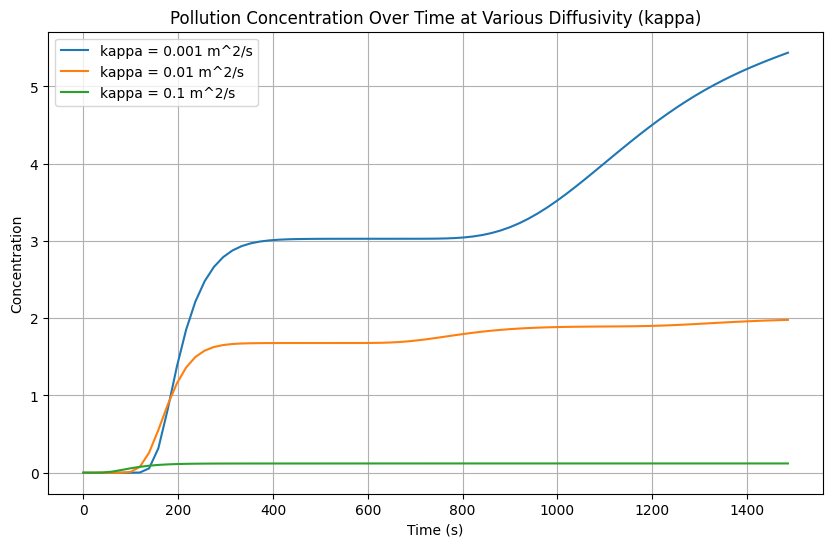

In [15]:
# Prepare to plot for varying kappa
plt.figure(figsize=(10, 6))
kappa_list = [1e-3, 1e-2, 1e-1] # Varying diffusivity values
for kappa_i in kappa_list:
    c_concentration, t_sim_save = simulate_pollution(U0=0.1, kappa=kappa_i)
    concentration_over_time = c_concentration[:, x_indices, y_indices]
    plt.plot(t_sim_save, concentration_over_time, label=f'kappa = {kappa_i} m^2/s')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various Diffusivity (kappa)')
plt.legend()
plt.grid()
plt.show()

At the very beginning, the initial rises in concentrations (from $t=0$ to $t=160$) can be observed more quickly as the corresponding $\kappa$ increases. This is because the higher the diffusivity $\kappa$, the more quickly the pollutant spreads from $x=10$ to $x=20$.

However, after the concentrations start to increase, the lower the value of $\kappa$, the higher the measured concentration value at $x=20$, $y=2$. This is because the higher the value of $\kappa$, the more uniformly the pollutant spreads to other points in the river, avoiding accumulation at $x=20$, $y=2$.

ADD DISCUSSION HERE

 Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

 $time\ needed\ to\ reach\ opposite\ side\ t \sim \frac{h^2}{D} \sim 10^4 s$

 $downstream\ distance\ x \sim U_0 \frac{h^2}{D} \sim 10^3m$

In [16]:
import numpy as np
time_opp_side = np.square(10)/(1e-2)
print("time needed to reach opposite side ~",time_opp_side, "s")
downstream_distance = 0.1*np.square(10)/(1e-2)
print("downstream distance~",downstream_distance,"m")

time needed to reach opposite side ~ 10000.0 s
downstream distance~ 1000.0 m


### Turbulent diffusion
In a turbulent flow, tracers will be transported by the turbulent eddies. A common way to model this is to introduce a turbulent diffusivity, $\kappa_T\sim u*l$, where $u$ and $l$ are characteristic velocity and length scales associated with the turbulent eddies.

To explore this effect, create a Dedalus script that includes advection by $u$ and $v$ (the $x$ and $y$ components of the velocity). Then, use the same velocity field as above for $u$ and add to that a fluctuating velocity field that of the form

$$ u=u_0 cos(kx)cos(ky), \quad v=u_0 sin(kx)sin(ky) $$

where $k$ is the wavenumber associated with the velocity fluctuations and $u_0$ is the amplitude of the fluctuations. Note that $k$ should be set to give an integer number of wavelengths in the $x$ and $y$ directions. Vary both $u_0$ and $k$ and study how quicky the tracer is transported across the river. Qualitatively compare this with the expectation based on the hypothesis of turbulent diffusion.

In [24]:
def simulate_turbulent_pollution(u0, k):
    import numpy as np
    import matplotlib.pyplot as plt
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)


  # Set parameters
    U0 = 0.1 # maximum current speed in m/s
    w = 10 # width of the river in m
    L = 50 # length of the river section to simulate
    kappa = 1e-2 # diffusivity in m^2/s
    S0 = 1 # amplitude of the pollution source term
    S_w = 1 # width of the source term in m
    S_x = 10 # center of the forcing in x
    S_y = 0 # center of the forcing in y
    S_t = 1 # forcing timescale

    # Numerical parameters
    Nx = 256 # number of gridoints in x
    Ny = 32 # number of gridpoints in y
    stop_sim_time=1500 # end time in seconds
    timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

    import numpy as np
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='c', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    v = dist.Field(name='v', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0)+ u0*np.cos(k*x)*np.cos(k*y) # parabolic velocity profile
    v['g'] = u0*np.sin(k*x)*np.sin(k*y) # parabolic velocity profile
    # kappa_t = u*l

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    #problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("dt(c) + dx(u*c) + lift(v*grad_c) - kappa*div(grad_c) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])];

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)

    return c_save, np.array(t_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 9s, Remaining: 0s, Rate: 1.1e-01/s


2025-11-11 23:15:14,255 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 9s, Remaining: 0s, Rate: 1.1e-01/s


INFO:__main__:Starting main loop


2025-11-11 23:15:14,261 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-11 23:16:39,096 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-11 23:16:41,333 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-11 23:16:43,452 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-11 23:16:45,642 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-11 23:16:47,994 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-11 23:16:50,118 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-11 23:16:52,247 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-11 23:16:54,369 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-11 23:16:56,504 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-11 23:16:58,907 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-11 23:17:01,193 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-11 23:17:03,305 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-11 23:17:05,416 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-11 23:17:07,544 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-11 23:17:09,772 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-11 23:17:12,320 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-11 23:17:14,652 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-11 23:17:16,867 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-11 23:17:19,051 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-11 23:17:21,334 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-11 23:17:23,542 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-11 23:17:25,885 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-11 23:17:28,003 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-11 23:17:30,120 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-11 23:17:32,353 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-11 23:17:34,751 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-11 23:17:37,302 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-11 23:17:39,661 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-11 23:17:41,980 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-11 23:17:44,096 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-11 23:17:46,221 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-11 23:17:48,370 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-11 23:17:50,743 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-11 23:17:52,872 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-11 23:17:55,137 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-11 23:17:57,466 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-11 23:17:59,863 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-11 23:18:02,355 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-11 23:18:04,585 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-11 23:18:06,866 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-11 23:18:09,153 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-11 23:18:11,272 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-11 23:18:13,614 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-11 23:18:15,978 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-11 23:18:18,309 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-11 23:18:20,735 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-11 23:18:23,045 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-11 23:18:25,164 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-11 23:18:27,458 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-11 23:18:29,674 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-11 23:18:31,790 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-11 23:18:33,906 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-11 23:18:36,020 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-11 23:18:38,316 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-11 23:18:40,847 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-11 23:18:42,965 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-11 23:18:45,359 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-11 23:18:47,477 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-11 23:18:49,589 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-11 23:18:51,838 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-11 23:18:54,130 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-11 23:18:56,249 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-11 23:18:58,372 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-11 23:19:01,164 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-11 23:19:03,466 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-11 23:19:05,826 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-11 23:19:07,958 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-11 23:19:10,064 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-11 23:19:12,170 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-11 23:19:14,290 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-11 23:19:16,587 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-11 23:19:19,026 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-11 23:19:21,433 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-11 23:19:23,856 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-11 23:19:26,270 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-11 23:19:28,606 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-11 23:19:31,103 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 23:19:32,585 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-11 23:19:32,587 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-11 23:19:32,590 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 9.34 sec


2025-11-11 23:19:32,593 solvers 0/1 INFO :: Setup time (init - iter 0): 9.34 sec


INFO:solvers:Warmup time (iter 0-10): 86.86 sec


2025-11-11 23:19:32,596 solvers 0/1 INFO :: Warmup time (iter 0-10): 86.86 sec


INFO:solvers:Run time (iter 10-end): 171.5 sec


2025-11-11 23:19:32,599 solvers 0/1 INFO :: Run time (iter 10-end): 171.5 sec


INFO:solvers:CPU time (iter 10-end): 0.04763 cpu-hr


2025-11-11 23:19:32,602 solvers 0/1 INFO :: CPU time (iter 10-end): 0.04763 cpu-hr


INFO:solvers:Speed: 7.666e+04 mode-stages/cpu-sec


2025-11-11 23:19:32,606 solvers 0/1 INFO :: Speed: 7.666e+04 mode-stages/cpu-sec


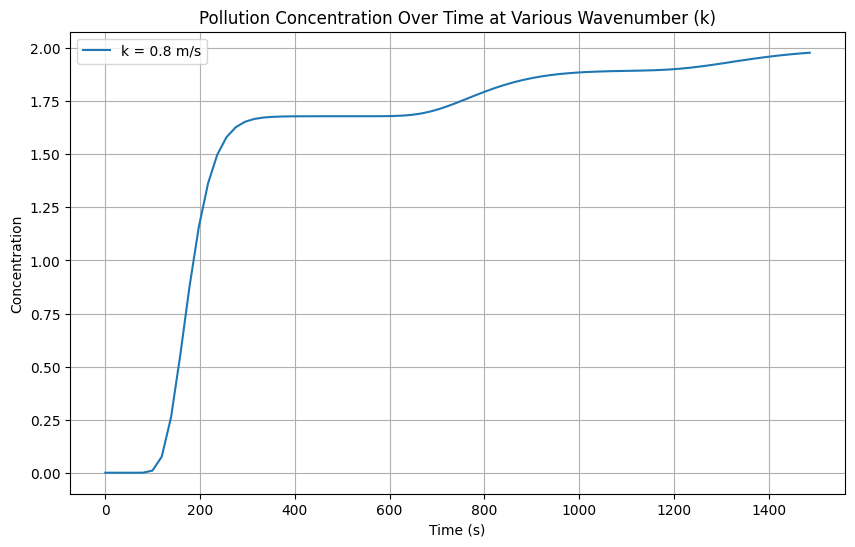

In [27]:
# Target coordinates
target_x = 20  # Example x coordinates in meters
target_y = 2   # Example y coordinates in meters
# Find the nearest indices
x_indices = (np.abs(x - target_x)).argmin()  # Nearest x index from simulation grid
y_indices = (np.abs(y - target_y)).argmin()  # Nearest y index from simulation grid

# Prepare to plot for varying U0
plt.figure(figsize=(10, 6))
k_list = [0.8]
for k_i in k_list:
    c_concentration, t_sim_save = simulate_turbulent_pollution(u0=0.0001, k=k_i)
    concentration_over_time = c_concentration[:, x_indices, y_indices]
    plt.plot(t_sim_save, concentration_over_time, label=f'k = {k_i} m/s')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various Wavenumber (k)')
plt.legend()
plt.grid()
plt.show()

INSERT PLOTS AND COMMENTS HERE

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.